# Capstone Project:
# Data Preparation <- This part won't be shown in M&G session, but in this stage is to get meaningful features as many as possible (<-some features were dropped due to non-realistic meaning, less variance, weak assumption had to make behind, some are transformed in EDA[Exploratory Data Analysis] part

# Data Cleaning <- Some statistical/logical/sensible ideas how to get/fill/transform to obtain/expend features in the following fields [Numerical, Categorical, Text (<-NLP to get sentimental and syntactic information),Time] <- This part may discuss during M&G, depending on the other side's interests

# Modelling: 
## Phase I: Restaurant Recommendation System

# Capstone Project Phase I: Restaurant Recommendation System (RRS)

## Purpose:
### Recommendation is not an actual regression or classification problem, based on the user past visited restaurants, this system will find other customers who are similar to the user [vectorise, customer matrix], according to their past experience, generate a list of restaurants the user may interested. Then the recommended restaurants will be generated based on similar customers historical data to the current user.

## Part I: Customer Similarity Compuatation:
## Assumption:
### 1.Similar users will highly likely have similar preference/interest in the target label<- Restaurants

## Approach:
### Cosine similarity to get similarity matrix and find the most n (<=10 by default) similar customers
### Count and sort similar restaurants all the similar customers visited before <= Get the most frequently visited restaurants
### Rank the baseline restaurant by stars and visit frequency

### Output: base line restaurants to generate restaurant recommendation for the user(<=must be in the database, otherwise it is a cold start, If it is a cold start, all not visited, It cannot find a explanable similarity <= limitation 1)

## Part II: Restaurant Recommendation:
## Assumption:
### 1.User matrix . Restaurant matrix => Rating matrix (svd:http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/svd.html)

### Output: 3 Recommended restaurants

## Approach:
### Cosine similarity to get similarity matrix and find the most n (<=3 by default) similar restaurants

## Part III: Customer Restaurant Rating Recommendation:
## Assumption:
### 1.There is a relationship between  customer, restaurant and rank

## Approach:
### KNN, SVD, Deep Learning

### Output: Recommended ranks for the 3 recommended restaurants <=Rank the 3 recommended restaurants for the user

## Part IV: Text filter and extraction:
## Output: wordcloud to give user and most frequent attribute/categories of the 3 restaurants and all attributes/categories the 3 restaurants have. <=The reason why it is recommended 

# Take a note: All data cleaning and preparation part won't be included in this notebook

In [1]:
import pandas as pd
import numpy as np
import json
import operator
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
############################################################
from surprise import Reader, Dataset, SVD, evaluate
from surprise import KNNBasic
from surprise.accuracy import rmse
from surprise import dump
############################################################
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Start I: Customer Similarity Compuatation

In [2]:
df_matrix3=pd.read_csv('./rec_temp_11_Nov.csv')
df_matrix3.rename({'Unnamed: 0':'user'},axis=1,inplace=True)
df_matrix3.restaurant_dictionary=df_matrix3.restaurant_dictionary.apply(literal_eval)

In [3]:
def find_n_most_similar_customer(user_id,start_col='Kazu',end_col='La Folie',n_of_similar_user=10):
    top_n_similar_user_id=[]
    top_n_similar_user_similarity=[]
    user_similarity=cosine_similarity(df_matrix3.loc[:,start_col:end_col],df_matrix3.loc[:,start_col:end_col])
    top_n_similar_user_id=np.argsort(user_similarity)[user_id][-(n_of_similar_user+1):-1]
    for similar_user_id in top_n_similar_user_id:
        top_n_similar_user_similarity.append(user_similarity[user_id][similar_user_id])
    
    print('Customer%d has %d similar users who are:'%(user_id,n_of_similar_user))
    print(top_n_similar_user_id)
    print('The similarity to customer%d are:'%user_id)
    print(top_n_similar_user_similarity)
    print('-'*110)
    similar_dict=dict(zip(top_n_similar_user_id,top_n_similar_user_similarity))
    print(similar_dict)    
    return similar_dict

In [5]:
def find_most_popular_restaurants_rated_by_similar_customers(user_list):
    temp_keys=[]
    for user in user_list:
        temp_keys.extend(list(df_matrix3.restaurant_dictionary[user].keys()))
    #print(temp_keys)
    c = Counter(temp_keys)
    dict_c=dict(c.most_common(10))#10 most commonly visited restaurants
    #print (dict(c.most_common(10)))
    
    restaurant_rate_dict={}
    for item in np.unique(temp_keys):# Calculate averaged rating of unique restaurants by similar customers
        temp_restaurant_rates=[]
        for user in user_list:#find all users who visited same restaurants and get the mean rating 
            if item in df_matrix3.restaurant_dictionary[user].keys():
                temp_restaurant_rates.append(float(df_matrix3.restaurant_dictionary[user][item]))
        restaurant_rate_dict[item]=np.mean(temp_restaurant_rates)
    #print(restaurant_rate_dict)   
    rest_list=[]
    for key in dict_c.keys():
        if key in dict(sorted(restaurant_rate_dict.items(), key=operator.itemgetter(1),reverse=True)[:round(len(np.unique(temp_keys))/3)]).keys():
            rest_list.append(key)
    print('Those customers like you are highly likely choose restaurant:')
    #print('Recommendation Base: 'rest_list)
    return rest_list
    #print(rest_list)
    #print(len(np.unique(temp_keys)))

In [6]:
rest_baseline=find_most_popular_restaurants_rated_by_similar_customers(find_n_most_similar_customer(1,start_col='Kazu',end_col='La Folie',n_of_similar_user=10))

Customer1 has 10 similar users who are:
[ 660 2747 2038 1991  270  519  136 2029 1397 1679]
The similarity to customer1 are:
[0.36298586076615, 0.3664995809446187, 0.3716090549072162, 0.37506656463749266, 0.38438800334536877, 0.3987783987361978, 0.4168439339227895, 0.42107596053325946, 0.5160661630703738, 0.549749371416928]
--------------------------------------------------------------------------------------------------------------
{660: 0.36298586076615, 2747: 0.3664995809446187, 2038: 0.3716090549072162, 1991: 0.37506656463749266, 270: 0.38438800334536877, 519: 0.3987783987361978, 136: 0.4168439339227895, 2029: 0.42107596053325946, 1397: 0.5160661630703738, 1679: 0.549749371416928}
Those customers like you are highly likely choose restaurant:


# Continue II: Restaurant Recommendation

In [7]:
df_business_QC=pd.read_csv('./yelp_business_to_use_nov_8_QC.csv')

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


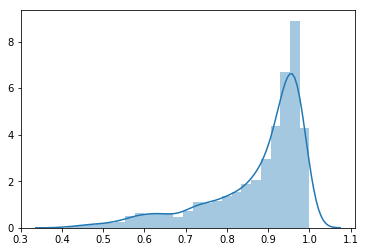

In [8]:
num_col=['name','city','review_count','stars','BikeParking','Caters',
         'GoodForKids','HasTV','OutdoorSeating','RestaurantsDelivery',
         'RestaurantsGoodForGroups','RestaurantsPriceRange2','RestaurantsReservations','RestaurantsTableService',
        'Monday_num_of_chkins','Tuesday_num_of_chkins','Wednesday_num_of_chkins','Thursday_num_of_chkins',
         'Friday_num_of_chkins','Saturday_num_of_chkins','Sunday_num_of_chkins','review_year_diff']
start_col='review_count'
end_col='review_year_diff'
df_restaurant_matrix=df_business_QC[num_col]
df_restaurant_matrix=df_restaurant_matrix.reset_index()
df_restaurant_matrix.rename({'index':'restaurant_index',},axis='columns',inplace=True)
df_restaurant_matrix.restaurant_index=df_restaurant_matrix.restaurant_index.map(lambda x:'restaurant'+str(x))
df_restaurant_matrix=df_restaurant_matrix.reset_index()
df_restaurant_matrix.rename({'index':'restaurant',},axis='columns',inplace=True)
vec=CountVectorizer(stop_words='english')
df_attr_cat_one_hot=pd.DataFrame(vec.fit_transform(df_business_QC.categories_clean+df_business_QC.attribute).toarray(),columns=vec.get_feature_names())
df_restaurant_matrix=df_restaurant_matrix.fillna(0)
df_restaurant_matrix=pd.concat([df_restaurant_matrix,df_attr_cat_one_hot],axis=1)
sns.distplot(cosine_similarity(df_restaurant_matrix.loc[:,'review_count':],df_restaurant_matrix.loc[:,'review_count':])[0])

In [9]:
'''
some restaurant variable using short form of rest
'''
def generate_n_most_similar_restaurant(rest_list,start_col='review_count',end_col='wings',n_of_similar_restaurant=10,n_of_recommended_restaurant=3):
    top_n_similar_user_rest_preference_id=[]
    for restaurant in rest_list:
        top_n_similar_user_rest_preference_id.extend(df_restaurant_matrix[df_restaurant_matrix.name==restaurant].index)
    top_n_similar_user_rest_preference_id=list(np.unique(top_n_similar_user_rest_preference_id))#Get similar customers' restaurants index preference
    #print(top_n_similar_user_rest_preference_id)
    
    df_ref=pd.DataFrame(columns=df_restaurant_matrix.loc[:,start_col:].columns)#temp avg scored user_preference_vector
    df_ref.loc[0,:]=df_restaurant_matrix.loc[top_n_similar_user_rest_preference_id,start_col:].mean()
    
    restaurant_similarity=cosine_similarity(df_ref,df_restaurant_matrix.loc[:,start_col:]) #compute restaurants similarity
    
    #recommended_rest_list=[]
    #for rest_index in top_n_similar_user_rest_preference_id:
    top_n_similar_rest_id=np.argsort(restaurant_similarity)[0][-(n_of_similar_restaurant+1):-1]
    top_3_recomend_rest=list(df_business_QC.loc[top_n_similar_rest_id,'stars'].sort_values(ascending=False)[:n_of_recommended_restaurant].index)
    #recommended_rest_list.extend(top_3_recomend_rest)
    print('Recommended 3 Top Restaurants ID: '+ str(top_3_recomend_rest))
    rest_name_3_top=[]
    for ind in top_3_recomend_rest:
        rest_name_3_top.append(df_business_QC.loc[ind,'name'])
    print('Recommended 3 Top Restaurants Name: '+ str(rest_name_3_top))
    #print(list(np.unique(top_3_recomend_rest)))
    return top_3_recomend_rest

In [10]:
user_reg=1
generate_n_most_similar_restaurant(find_most_popular_restaurants_rated_by_similar_customers(find_n_most_similar_customer(user_reg,start_col='Kazu',end_col='La Folie',n_of_similar_user=10)))

Customer1 has 10 similar users who are:
[ 660 2747 2038 1991  270  519  136 2029 1397 1679]
The similarity to customer1 are:
[0.36298586076615, 0.3664995809446187, 0.3716090549072162, 0.37506656463749266, 0.38438800334536877, 0.3987783987361978, 0.4168439339227895, 0.42107596053325946, 0.5160661630703738, 0.549749371416928]
--------------------------------------------------------------------------------------------------------------
{660: 0.36298586076615, 2747: 0.3664995809446187, 2038: 0.3716090549072162, 1991: 0.37506656463749266, 270: 0.38438800334536877, 519: 0.3987783987361978, 136: 0.4168439339227895, 2029: 0.42107596053325946, 1397: 0.5160661630703738, 1679: 0.549749371416928}
Those customers like you are highly likely choose restaurant:
Recommended 3 Top Restaurants ID: [283, 1185, 627]
Recommended 3 Top Restaurants Name: ['Maison Boulud', 'Ma Poule Mouillée', "L'Avenue"]


[283, 1185, 627]

# Continue III: User Rating Recommendation

In [11]:
df_review_user_rest=pd.read_csv('./rating_recommendation_base_15_nov.csv')
df_rating_matrix=df_review_user_rest[['user','restaurant','stars']]
df_rating_matrix=df_rating_matrix.pivot(index = 'user', columns ='restaurant', values = 'stars').fillna(0)

In [12]:
reader = Reader()
data = Dataset.load_from_df(df_review_user_rest[['user','restaurant','stars']], reader)
data.split(n_folds=5)

In [29]:
# Use the SVD algorithm.
# Example using cosine similarity
sim_options_cos = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
# Example using pearson_baseline similarity
sim_options_base = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }

svd = SVD()
knn_base = KNNBasic(sim_options=sim_options_base)
knn_cos = KNNBasic(sim_options=sim_options_cos)
# Compute the RMSE of the SVD algorithm.
#evaluate(svd, data, measures=['RMSE'])

for trainset, testset in data.folds(): 
    svd.train(trainset)                             
    predictions_svd = svd.test(testset)

    knn_base.train(trainset)
    predictions_knn_base = knn_base.test(testset)

    knn_cos.train(trainset)
    predictions_knn_cos = knn_cos.test(testset)
    
    print('SVD')
    rmse(predictions_svd)
    print('-'*25)
    print('KNN_Base')
    rmse(predictions_knn_base)
    print('-'*25)
    print('KNN_Cos')
    rmse(predictions_knn_cos)
    print('-'*25)
    
    dump.dump('./dump_SVD', predictions_svd, svd)
    dump.dump('./dump_KNN_base', predictions_knn_base, knn_base)
    dump.dump('./dump_KNN_cos', predictions_knn_cos, knn_cos)

C:\Users\User\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD
RMSE: 0.9650
-------------------------
KNN_Base
RMSE: 1.1230
-------------------------
KNN_Cos
RMSE: 1.0819
-------------------------


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD
RMSE: 0.9830
-------------------------
KNN_Base
RMSE: 1.1286
-------------------------
KNN_Cos
RMSE: 1.0990
-------------------------


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD
RMSE: 0.9680
-------------------------
KNN_Base
RMSE: 1.1247
-------------------------
KNN_Cos
RMSE: 1.0931
-------------------------


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD
RMSE: 0.9703
-------------------------
KNN_Base
RMSE: 1.1381
-------------------------
KNN_Cos
RMSE: 1.0924
-------------------------


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...


C:\Users\User\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
SVD
RMSE: 0.9762
-------------------------
KNN_Base
RMSE: 1.1361
-------------------------
KNN_Cos
RMSE: 1.0990
-------------------------


In [13]:
predictions_svd, algo_svd = dump.load('./dump_SVD')
df_svd = pd.DataFrame(predictions_svd, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_svd['err'] = abs(df_svd.est - df_svd.rui)

In [14]:
abs(df_svd.est.map(lambda x:np.round(x,0))-df_svd.rui).sum()

5409.0

In [15]:
df_svd.err.sum()

5687.092987292062

In [16]:
user=user_reg
restaurant_rec=generate_n_most_similar_restaurant(find_most_popular_restaurants_rated_by_similar_customers(find_n_most_similar_customer(user_reg,start_col='Kazu',end_col='La Folie',n_of_similar_user=10)))

Customer1 has 10 similar users who are:
[ 660 2747 2038 1991  270  519  136 2029 1397 1679]
The similarity to customer1 are:
[0.36298586076615, 0.3664995809446187, 0.3716090549072162, 0.37506656463749266, 0.38438800334536877, 0.3987783987361978, 0.4168439339227895, 0.42107596053325946, 0.5160661630703738, 0.549749371416928]
--------------------------------------------------------------------------------------------------------------
{660: 0.36298586076615, 2747: 0.3664995809446187, 2038: 0.3716090549072162, 1991: 0.37506656463749266, 270: 0.38438800334536877, 519: 0.3987783987361978, 136: 0.4168439339227895, 2029: 0.42107596053325946, 1397: 0.5160661630703738, 1679: 0.549749371416928}
Those customers like you are highly likely choose restaurant:
Recommended 3 Top Restaurants ID: [283, 1185, 627]
Recommended 3 Top Restaurants Name: ['Maison Boulud', 'Ma Poule Mouillée', "L'Avenue"]


In [35]:
for rest in restaurant_rec:
    algo_svd.predict(uid=user, iid=rest, r_ui=0, verbose=True)

user: 1          item: 283        r_ui = 0.00   est = 4.86   {'was_impossible': False}
user: 1          item: 1185       r_ui = 0.00   est = 4.90   {'was_impossible': False}
user: 1          item: 627        r_ui = 0.00   est = 4.78   {'was_impossible': False}


In [42]:
'''
Base
'''
df_business_QC[df_business_QC.name.isin(rest_baseline)][['name','attribute','categories_clean']].T

,34,239,402,627
name,L'Avenue,Tommy,Pikolo,L'Avenue
attribute,"['full_bar', ' casual', ' street', ' brunch', ...","[' casual', ' street', ' brunch', 'average', '...","[' casual', ' street', ' breakfast', 'average'...","['full_bar', ' trendy', ' street', ' brunch', ..."
categories_clean,[' breakfast & brunch'],"[' breakfast & brunch', ' coffee & tea', ' caf...","['breakfast & brunch', ' cafes', ' coffee & tea']","['breakfast & brunch', ' canadian (new)', ' bu..."


In [50]:
'''
Recommeded
'''
df_business_QC.loc[restaurant_rec,:][['name','attribute','categories_clean']].T

,283,1185,627
name,Maison Boulud,Ma Poule Mouillée,L'Avenue
attribute,"['full_bar', ' upscale', ' valet', ' brunch', ...","[' casual', ' street', ' dinner', 'average', '...","['full_bar', ' trendy', ' street', ' brunch', ..."
categories_clean,"['breakfast & brunch', ' french']",['portuguese'],"['breakfast & brunch', ' canadian (new)', ' bu..."


# Visulisation

In [51]:
print(rest_baseline)
print(restaurant_rec)

["L'Avenue", 'Tommy', 'Pikolo']
[283, 1185, 627]


In [45]:
base_word_list=(df_business_QC[df_business_QC.name.isin(rest_baseline)]['attribute']+df_business_QC[df_business_QC.name.isin(rest_baseline)]['categories_clean']).sum().replace('[','').replace(']','').replace(' ','').split("'")
base_word_list=[x for x in base_word_list if x !=',']
base_word_list=' '.join(base_word_list).split()
base_word_list=list(np.unique(base_word_list))

In [52]:
rec_word_list_0=(df_business_QC[df_business_QC.index.isin(restaurant_rec)]['attribute'].loc[restaurant_rec[0]]+df_business_QC[df_business_QC.index.isin(restaurant_rec)]['categories_clean'].loc[restaurant_rec[0]]).replace('[','').replace(']','').replace(' ','').split("'")
rec_word_list_0=[x for x in rec_word_list_0 if x !=',']
rec_word_list_0=' '.join(rec_word_list_0).split()
rec_word_list_1=(df_business_QC[df_business_QC.index.isin(restaurant_rec)]['attribute'].loc[restaurant_rec[1]]+df_business_QC[df_business_QC.index.isin(restaurant_rec)]['categories_clean'].loc[restaurant_rec[1]]).replace('[','').replace(']','').replace(' ','').split("'")
rec_word_list_1=[x for x in rec_word_list_1 if x !=',']
rec_word_list_1=' '.join(rec_word_list_1).split()
rec_word_list_2=(df_business_QC[df_business_QC.index.isin(restaurant_rec)]['attribute'].loc[restaurant_rec[2]]+df_business_QC[df_business_QC.index.isin(restaurant_rec)]['categories_clean'].loc[restaurant_rec[2]]).replace('[','').replace(']','').replace(' ','').split("'")
rec_word_list_2=[x for x in rec_word_list_2 if x !=',']
rec_word_list_2=' '.join(rec_word_list_2).split()

In [53]:
word_cloud_list=[x for x in rec_word_list_2 if x in base_word_list]+[x for x in rec_word_list_0 if x in base_word_list]+[x for x in rec_word_list_1 if x in base_word_list]

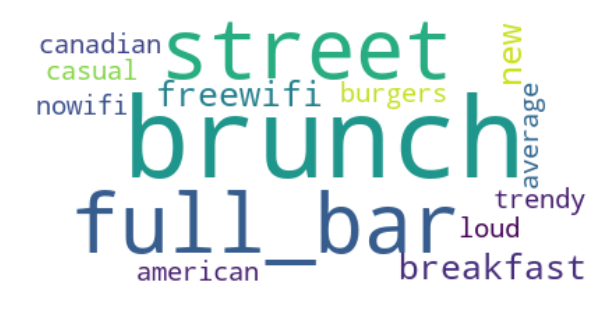

In [59]:
STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,max_font_size=80, max_words=100, background_color="white").generate(str(word_cloud_list).replace("'"," ").replace('&',' '))

# Display the generated image:
plt.figure(figsize=[10,8])
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# Deeplearning Rating

In [116]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.models import Model

import pydot
import graphviz

from sklearn.model_selection import train_test_split

In [61]:
df_data=df_review_user_rest[['user','restaurant','stars','date']]

In [65]:
n_users, n_restaurants = len(df_data.user.unique()), df_data.restaurant.max()
n_latent_factors = 3

In [63]:
train, test = train_test_split(df_data, test_size=0.2,random_state=5)

In [117]:
restaurant_input = keras.layers.Input(shape=[1],name='Item')
restaurant_embedding = keras.layers.Embedding(n_restaurants + 1, n_latent_factors, name='Restaurant-Embedding')(restaurant_input)
restaurant_vec = keras.layers.Flatten(name='FlattenRestaurants')(restaurant_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([restaurant_vec, user_vec], mode='dot',name='DotProduct')
model = Model([user_input, restaurant_input], prod)
model.compile('adam', 'mean_squared_error')

C:\Users\User\Anaconda3\lib\site-packages\keras\legacy\layers.py:429: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `sum`, `concatenate`, etc.
  warnings.warn('The `merge` function is deprecated '
C:\Users\User\Anaconda3\lib\site-packages\keras\legacy\layers.py:66: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  warnings.warn('The `Merge` layer is deprecated '


In [127]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Item (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
User (InputLayer)                (None, 1)             0                                            
____________________________________________________________________________________________________
Restaurant-Embedding (Embedding) (None, 1, 3)          4641                                         
____________________________________________________________________________________________________
User-Embedding (Embedding)       (None, 1, 3)          9009                                         
___________________________________________________________________________________________

In [128]:
history = model.fit([train.user, train.restaurant], train.stars, epochs=100, verbose=0)

Text(0,0.5,'Train Error')

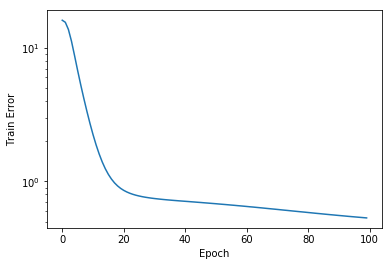

In [129]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [149]:
y_hat = model.predict([test.user, test.restaurant])
y_hat_round = np.round(model.predict([test.user, test.restaurant]),0)
y_true = test.stars

In [140]:
y_hat.reshape(1,-1)[0]

array([3.8340874, 4.3038716, 4.060561 , ..., 4.4833784, 5.6487722,
       3.8875446], dtype=float32)

In [144]:
abs(y_hat.reshape(1,-1)[0]-y_true).sum()

6418.203212294728

In [148]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.8579338607532051

In [150]:
mean_absolute_error(y_true, y_hat_round)

0.8259590963774897

In [145]:
model.predict([test[test.user==1].user, test[test.restaurant==283].restaurant]).mean()

5.0632124

In [146]:
model.predict([test[test.user==1].user, test[test.restaurant==1185].restaurant]).mean()

5.319191

In [147]:
model.predict([test[test.user==1].user, test[test.restaurant==627].restaurant]).mean()

5.0753627

In [2]:
df_matrix3=pd.read_csv('./rec_temp_11_Nov.csv')
df_matrix3.rename({'Unnamed: 0':'user'},axis=1,inplace=True)
df_matrix3.restaurant_dictionary=df_matrix3.restaurant_dictionary.apply(literal_eval)

In [4]:
from sklearn.externals import joblib
import pickle

In [5]:
with open('customer_similarity_computation_data.pkl','wb') as file:
    pickle.dump(df_matrix3,file)

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


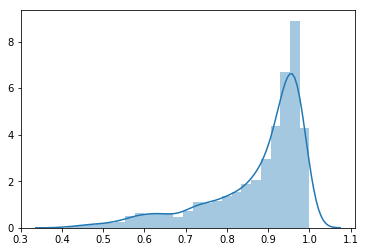

In [6]:
df_business_QC=pd.read_csv('./yelp_business_to_use_nov_8_QC.csv')
num_col=['name','city','review_count','stars','BikeParking','Caters',
         'GoodForKids','HasTV','OutdoorSeating','RestaurantsDelivery',
         'RestaurantsGoodForGroups','RestaurantsPriceRange2','RestaurantsReservations','RestaurantsTableService',
        'Monday_num_of_chkins','Tuesday_num_of_chkins','Wednesday_num_of_chkins','Thursday_num_of_chkins',
         'Friday_num_of_chkins','Saturday_num_of_chkins','Sunday_num_of_chkins','review_year_diff']
start_col='review_count'
end_col='review_year_diff'
df_restaurant_matrix=df_business_QC[num_col]
df_restaurant_matrix=df_restaurant_matrix.reset_index()
df_restaurant_matrix.rename({'index':'restaurant_index',},axis='columns',inplace=True)
df_restaurant_matrix.restaurant_index=df_restaurant_matrix.restaurant_index.map(lambda x:'restaurant'+str(x))
df_restaurant_matrix=df_restaurant_matrix.reset_index()
df_restaurant_matrix.rename({'index':'restaurant',},axis='columns',inplace=True)
vec=CountVectorizer(stop_words='english')
df_attr_cat_one_hot=pd.DataFrame(vec.fit_transform(df_business_QC.categories_clean+df_business_QC.attribute).toarray(),columns=vec.get_feature_names())
df_restaurant_matrix=df_restaurant_matrix.fillna(0)
df_restaurant_matrix=pd.concat([df_restaurant_matrix,df_attr_cat_one_hot],axis=1)
sns.distplot(cosine_similarity(df_restaurant_matrix.loc[:,'review_count':],df_restaurant_matrix.loc[:,'review_count':])[0])

In [7]:
with open('restaurant_similarity_computation_matrix_data.pkl','wb') as file:
    pickle.dump(df_restaurant_matrix,file)

In [8]:
with open('restaurant_to_display_QC_data.pkl','wb') as file:
    pickle.dump(df_business_QC,file)